<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Kavindu-Deshanjana/TimeSeries_Test_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


# Mounting the Google Drive
drive.mount('/content/drive')

# Reading the data from the excel file and removing blank spaces in each cell
df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/SL Apparel Industry Dataset.xlsx').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Reading the JoinDates.xlsx file
join_dates_df = pd.read_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/JoinedDates.xlsx')

# Merging the SL Apparel Industry Dataset with the Join Dates based on the 'Code' column
df = pd.merge(df, join_dates_df, on='Code', how='left')
print(df.head())

df['Date'] = pd.to_datetime(df['Date'])

df['Joined Date'] = pd.to_datetime(df['Joined Date'])
# Calculating the number of years each employee has worked
df['DaysWorked'] = (df['Date'] - df['Joined Date']).dt.days

# Making the 'Absenteeism Type' considered as String
df['Absenteeism Type'] = df['Absenteeism Type'].astype(str)

# Add a column for the day of the week (1-7)
df['DayOfWeek'] = df['Date'].dt.dayofweek + 1

# Add a column for the month (1-12)
df['Month'] = df['Date'].dt.month
print(df.head())
# Removing rows with 'Resignation', 'VOP', 'Funeral' from the 'Reason' column
reasons_to_remove = ['Resignation', 'VOP', 'Funeral']
df = df[~df['Reason'].isin(reasons_to_remove)]

# Removing rows where 'Leave Type' is 0.5
df = df[df['Leave Type'] != 0.5]

# Removing all the rows except for 'Shift A' and 'Shift B' in the 'Shift' column
df = df[df['Shift'] != 'A']
df = df[df['Shift'] != 'Shift']
df = df[df['Shift'] != 'Other Teams']
df = df[df['Shift'] != 'Shift e']

# Removing 'Department' and 'Reason Mapping' columns
df = df.drop(['Reason Mapping'], axis=1)

# Removing rows where 'Absenteeism Type' is 1
df = df[df['Absenteeism Type'] != '1']

# Using LabelEncoder to encode the values in columns
label_encoder = LabelEncoder()
df['Encoded Reason'] = label_encoder.fit_transform(df['Reason'])
df['Encoded Status'] = label_encoder.fit_transform(df['Status'])
df['Encoded Absenteeism Type'] = label_encoder.fit_transform(df['Absenteeism Type'])
df['Encoded Shift'] = label_encoder.fit_transform(df['Shift'])
df['TookLeaveNextMonth'] = (df['Absent/Present'].eq('Absent') & (df['Date'].dt.month != (df['Date'] + pd.DateOffset(months=1)).dt.month)).astype(int)

# Removing the rows if it has a blank cell in it
df = df.dropna()
# Print intermediate results for debugging
print("Columns after preprocessing:")
print(df.head())

# Creating a mapping dictionary with the original values for clear understanding
reason_mapping = {
    'Reason': dict(zip(df['Encoded Reason'], df['Reason'])),
    'Status': dict(zip(df['Encoded Status'], df['Status'])),
    'Absenteeism_Type': dict(zip(df['Encoded Absenteeism Type'], df['Absenteeism Type'])),
    'Shift': dict(zip(df['Encoded Shift'], df['Shift']))
}

# Save the mapping dictionary to a text file
with open('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/reason_mapping.txt', 'w') as f:
    for category, mappings in reason_mapping.items():
        f.write(f"{category}:\n")
        for encoded_value, original_value in mappings.items():
            f.write(f"  {encoded_value}: {original_value}\n")

# Print intermediate results for debugging
print("Columns before saving to Excel:")
print(df.head())

# Save the new preprocessed data to a new excel file in Google Drive
df.to_excel('/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/preprocessed_data.xlsx', index=False)
print("Done")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        Date    Shift   Code          Department Absenteeism Type    Status  \
0 2021-12-01  Shift A  AA369  Team - MAT 4A - BD         Informed  Notified   
1 2021-12-01  Shift A  AA362  Team - MAT 4A - BD         Informed  Notified   
2 2021-12-01  Shift A  AA359  Team - MAT 4A - BD         Informed  Notified   
3 2021-12-01  Shift A  AA541  Team - MAT 4A - BD         Informed  Notified   
4 2021-12-01  Shift A  AA398  Team - MAT 3A - BD         Informed  Notified   

   Reason Mapping  Leave Type Absent/Present     Reason Joined Date  
0             NaN         1.0            MAT  Maternity  2015-09-11  
1             NaN         1.0            MAT  Maternity  2018-11-14  
2             NaN         1.0            MAT  Maternity  2019-10-09  
3             NaN         1.0            MAT  Maternity  2020-10-02  
4             NaN         1.0            MAT  

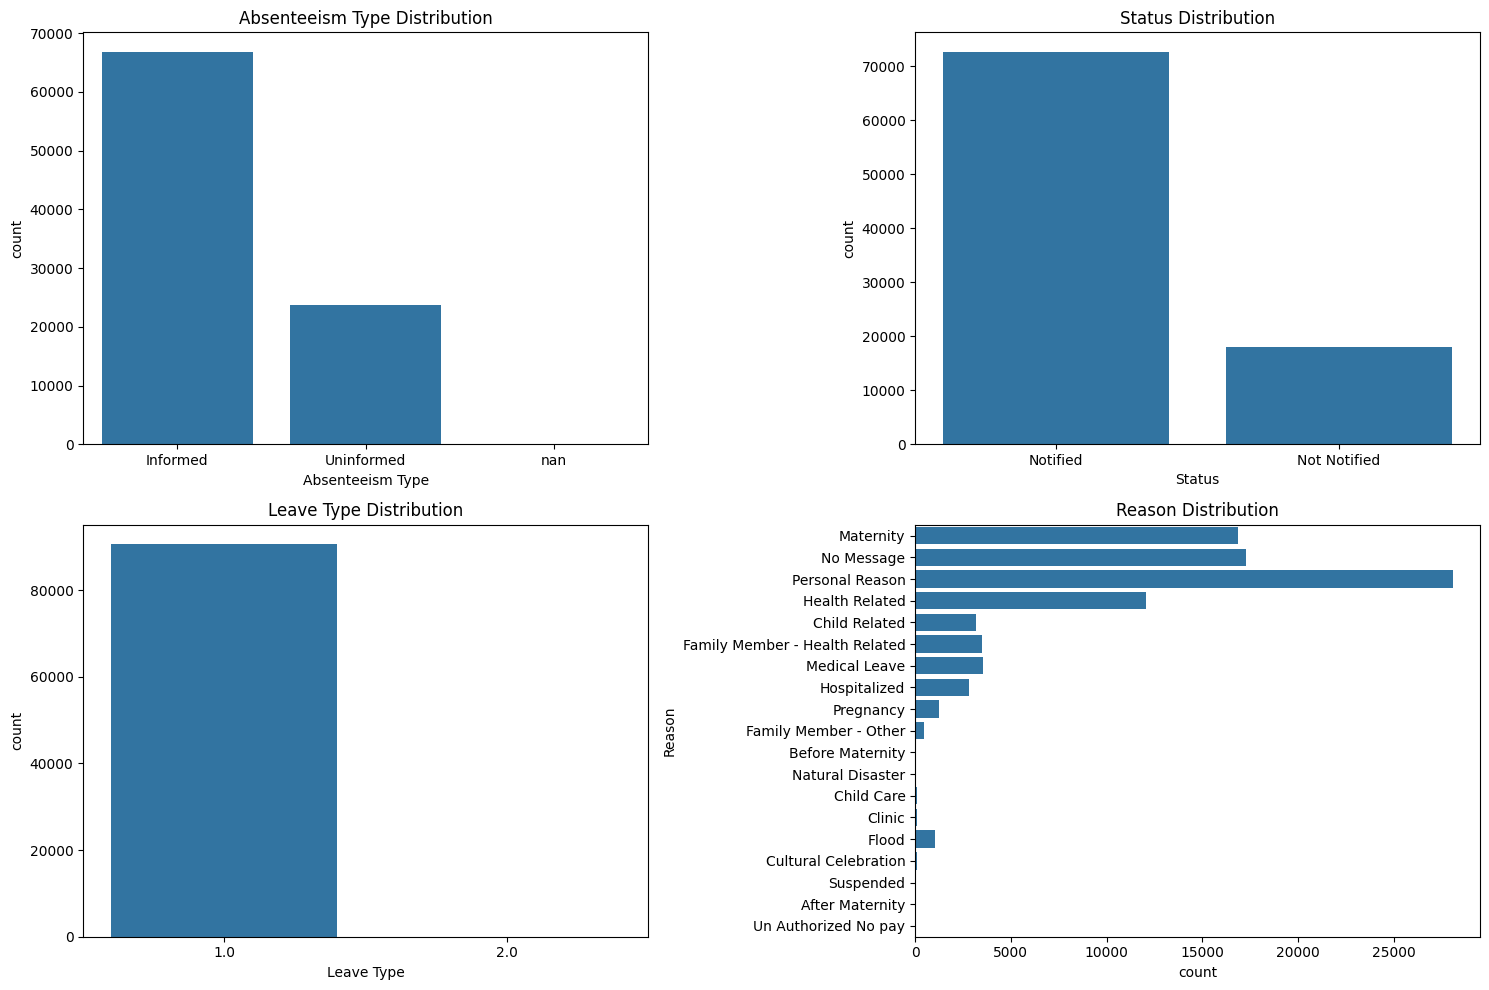

<ipython-input-48-b4d6cc88c908>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='DaysWorked', ax=axes[0, 1], palette='Blues')
<ipython-input-48-b4d6cc88c908>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dayofweek', y='DaysWorked', ax=axes[1, 0], palette='Greens')
<ipython-input-48-b4d6cc88c908>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='quarter', y='DaysWorked', ax=axes[1, 1], palette='Reds')


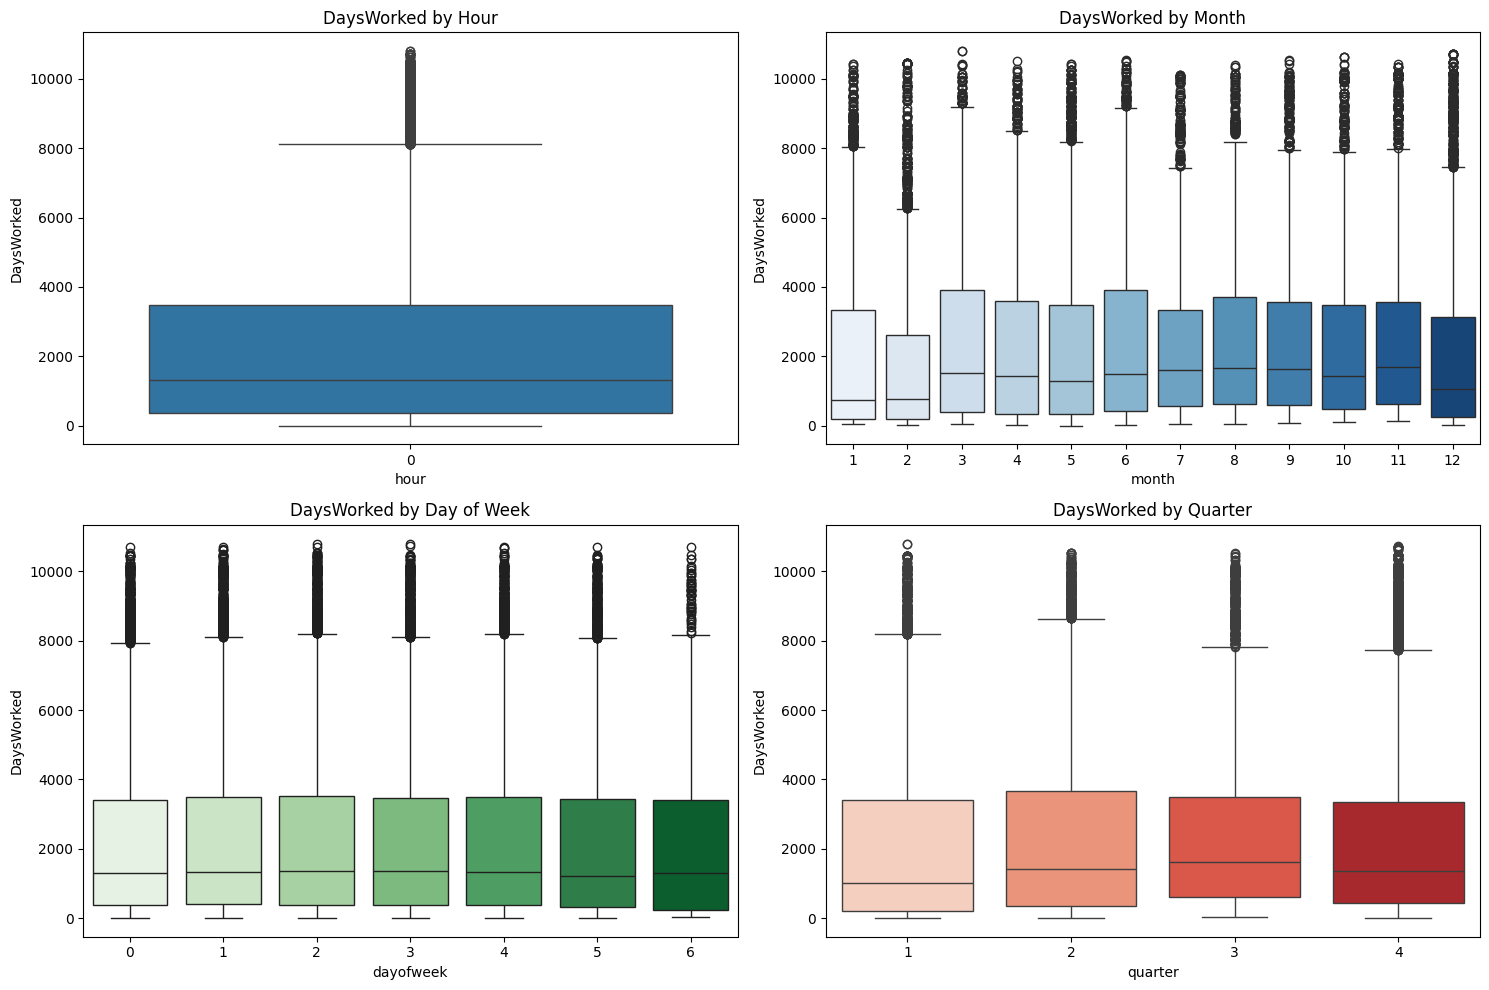

KeyError: 'Date'

In [48]:

# Visualize data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot Absenteeism Type distribution
sns.countplot(data=df, x='Absenteeism Type', ax=axes[0, 0])
axes[0, 0].set_title('Absenteeism Type Distribution')

# Plot Status distribution
sns.countplot(data=df, x='Status', ax=axes[0, 1])
axes[0, 1].set_title('Status Distribution')

# Plot Leave Type distribution
sns.countplot(data=df, x='Leave Type', ax=axes[1, 0])
axes[1, 0].set_title('Leave Type Distribution')

# Plot Reason distribution
sns.countplot(data=df, y='Reason', ax=axes[1, 1])
axes[1, 1].set_title('Reason Distribution')
plt.tight_layout()
plt.show()

# Create time series features
def create_time_series_features(df):
    """
    Create time series features based on 'Date' column.
    """
    df['hour'] = df['Date'].dt.hour
    # df['Date'] = df['Date'].dt.Date
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    return df
    # df['hour'] = df['Joined Date'].dt.hour
    # df['dayofweek'] = df['Joined Date'].dt.dayofweek
    # df['quarter'] = df['Joined Date'].dt.quarter
    # df['month'] = df['Joined Date'].dt.month
    # df['year'] = df['Joined Date'].dt.year
    # df['dayofyear'] = df['Joined Date'].dt.dayofyear
    # df['dayofmonth'] = df['Joined Date'].dt.day
    # df['weekofyear'] = df['Joined Date'].dt.isocalendar().week
    # return df

# Apply function to create time series features
df = create_time_series_features(df)

# Visualize time series features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# Plot DaysWorked by Hour
sns.boxplot(data=df, x='hour', y='DaysWorked', ax=axes[0, 0])
axes[0, 0].set_title('DaysWorked by Hour')

# Plot DaysWorked by Month
sns.boxplot(data=df, x='month', y='DaysWorked', ax=axes[0, 1], palette='Blues')
axes[0, 1].set_title('DaysWorked by Month')

# Plot DaysWorked by Day of Week
sns.boxplot(data=df, x='dayofweek', y='DaysWorked', ax=axes[1, 0], palette='Greens')
axes[1, 0].set_title('DaysWorked by Day of Week')

# Plot DaysWorked by Quarter
sns.boxplot(data=df, x='quarter', y='DaysWorked', ax=axes[1, 1], palette='Reds')
axes[1, 1].set_title('DaysWorked by Quarter')

plt.tight_layout()
plt.show()

train = create_time_series_features(train)
test = create_time_series_features(test)

features =['Encoded Reason', 'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift', 'DaysWorked', 'DayOfWeek', 'Month']
target = 'TookLeaveNextMonth'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [49]:
train = create_time_series_features(train)
test = create_time_series_features(test)

features =['Encoded Reason', 'Encoded Status', 'Encoded Absenteeism Type', 'Encoded Shift', 'DaysWorked', 'DayOfWeek', 'Month']
target = 'TookLeaveNextMonth'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]





KeyError: 'Date'